In [1]:
# 加载必备库文件
import numpy as np

import mxnet as mx
from mxnet import nd
from mxnet import init
from mxnet import gluon
from mxnet import autograd

from mxnet.gluon import nn

In [2]:
res18_blk_num  = [2, 2, 2,  2] # 不是 bottleneck
res50_blk_num  = [3, 4, 6,  3]
res101_blk_num = [3, 4, 23, 3]
res152_blk_num = [3, 8, 36, 3]

# 为了便于参数导入，变量名最好和 gluoncv 的变量名相同
class BottleneckV1b(gluon.HybridBlock):
    """res 基本模块"""
    def __init__(self, channels, strides, isdownsample=False, **kwargs):
        super(BottleneckV1b, self).__init__(**kwargs)
        # 一个 bottleneck 内， 1*1 卷积 channel 扩大的倍数
        self.expansion = 4
        self.isdownsample = isdownsample
        self.strides = strides

        
        # bottletneck 内总是 1*1 conv -- 3*3 conv -- 1*1 conv
        self.conv1 = nn.Conv2D(channels=channels, kernel_size=(1,1), strides=(1,1),
                               padding=(0,0), groups=1, use_bias=False)
        self.bn1   = nn.BatchNorm() # use_global_stats=True 默认为 False
        self.relu  = nn.Activation('relu')
        
        self.conv2 = nn.Conv2D(channels=channels, kernel_size=3, strides=self.strides,
                               padding=(1,1), groups=1, use_bias=False)
        self.bn2   = nn.BatchNorm()
        
        self.conv3 = nn.Conv2D(channels=channels * self.expansion, kernel_size=(1,1), strides=(1,1),
                               padding=(0,0), groups=1, use_bias=False)
        self.bn3   = nn.BatchNorm()
        
        if self.isdownsample:
            self.downsample = nn.HybridSequential()
            self.downsample.add(nn.Conv2D(channels=channels * self.expansion, kernel_size=(1,1), strides=self.strides,
                                         padding=(0,0), groups=1, use_bias=False),
                                nn.BatchNorm())


    def hybrid_forward(self, F, x):
        residual = self.relu(self.bn1(self.conv1(x)))
        residual = self.relu(self.bn2(self.conv2(residual)))
        residual = self.bn3(self.conv3(residual))

        if self.isdownsample:
            x = self.downsample(x)

        x = x + residual
        out = self.relu(x)

        return out


In [ ]:
net = BottleneckV1b(64, (2,2), isdownsample=True)
x = nd.random.uniform(shape=(1,1,224,224))
net.initialize(init.Xavier())
y = net(x)

In [3]:
class ResNet(gluon.HybridBlock):
    """ Pre-trained ResNetV1b Model, which produces the strides of 8
    featuremaps at conv5.

    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    norm_layer : object
        Normalization layer used (default: :class:`mxnet.gluon.nn.BatchNorm`)
        Can be :class:`mxnet.gluon.nn.BatchNorm` or :class:`mxnet.gluon.contrib.nn.SyncBatchNorm`.
    last_gamma : bool, default False
        Whether to initialize the gamma of the last BatchNorm layer in each bottleneck to zero.
    deep_stem : bool, default False
        Whether to replace the 7x7 conv1 with 3 3x3 convolution layers.
    avg_down : bool, default False
        Whether to use average pooling for projection skip connection between stages/downsample.
    final_drop : float, default 0.0
        Dropout ratio before the final classification layer.
    use_global_stats : bool, default False
        Whether forcing BatchNorm to use global statistics instead of minibatch statistics;
        optionally set to True if finetuning using ImageNet classification pretrained models.
    """
    # pylint: disable=unused-variable
    def __init__(self, block_nums, channels, strides, classes=1000, **kwargs):
        super(ResNet, self).__init__(**kwargs)

        self.features = nn.HybridSequential()
        self.features.add(nn.Conv2D(channels=64, kernel_size=(7,7), strides=(2,2),
                                    padding=(3,3), groups=1, use_bias=False))
        self.features.add(nn.BatchNorm())
        self.features.add(nn.Activation('relu'))
        self.features.add(nn.MaxPool2D(pool_size=(3,3), strides=(2,2), padding=(1,1)))
        
        # block_nums = [3, 4, 6, 3]
        # channels = [64, 128, 256, 512]
        # strides = [(1,1), (2,2), (2,2), (2,2)]
        for i in range(len(block_nums)):
            blk = nn.HybridSequential()
            for num in range(block_nums[i]) :
                if num == 0:
                    bottleneck = BottleneckV1b(channels[i], strides[i], isdownsample=True)
                else:
                    bottleneck = BottleneckV1b(channels[i], (1,1), isdownsample=False)
                blk.add(bottleneck)
            self.features.add(blk)

        self.avgpool = nn.GlobalAvgPool2D()
        self.out = nn.Dense(classes)

    def hybrid_forward(self, F, x):
        feature = self.features(x)
        out = self.avgpool(feature)
        out = self.out(out)
        return out

block_nums = [3, 4, 6, 3]
channels = [64, 128, 256, 512]
strides = [(1,1), (2,2), (2,2), (2,2)]

In [ ]:
net = ResNet(block_nums, channels, strides)
x = nd.random.uniform(shape=(1,1,224,224))
net.initialize(init.Xavier())
y = net(x)

In [ ]:
print(net)

In [4]:
def anchor_gen(ratios, scales, width, height, stride):
    """生成 anchor
    return (xmin, ymin, xmax, ymax)"""
    anchor = []
    for s in scales:
        for r in ratios:
            w = s / np.sqrt(r)
            w = np.round(w * 0.5)
            h = s * np.sqrt(r)
            h = np.round(h * 0.5)
            anchor.append([-w, -h, w, h])
            
    anchor = np.array(anchor)

    x = range(width)
    y = range(height)
    x, y = np.meshgrid(x, y)
    
    offsets = np.concatenate((x[:,:,np.newaxis], y[:,:,np.newaxis], x[:,:,np.newaxis], y[:,:,np.newaxis]), axis = -1)
    offsets *= stride
    #print(offsets.shape)
    #print(offsets)
    # 中心点需要向右下角偏移 stride // 2
    offsets += stride // 2
    #print(offsets)
    
    anchor = anchor.reshape(1, -1, 4) + offsets.reshape(-1,1,4)
    anchor = anchor.reshape(-1, 4)
    
    return anchor

ratios = [0.5, 1, 2]
scales = [32, 64, 128, 256, 512]

In [ ]:
anchor = anchor_gen(ratios, scales, 600//16, 800//16, 16)

In [5]:

def get_realbbox(bbox_pred, anchors, wh_max=4.42):
    """根据 anchor 得到预测边框的真实值
    bbox_pred, anchors 都是 numpy array 数据类型 (x, y, w, h) 形式，维度 (C,N,4)"""
    batch = bbox_pred.shape[0]

    x = bbox_pred[:,:,0] * anchors[:,:,2] + anchors[:,:,0]
    y = bbox_pred[:,:,1] * anchors[:,:,3] + anchors[:,:,1]
    w = anchors[:,:,2] * np.minimum(np.exp(bbox_pred[:,:,2]), wh_max)
    h = anchors[:,:,3] * np.minimum(np.exp(bbox_pred[:,:,3]), wh_max)

    return np.concatenate((x.reshape(batch,-1,1),y.reshape(batch,-1,1),
                           w.reshape(batch,-1,1),h.reshape(batch,-1,1)), axis=-1)

In [ ]:
a = np.arange(16).reshape(2,2,4) * 0.1
b = np.arange(8).reshape(1,2,4) * 0.3
print(a)
print(b)
get_realbbox(a,b)

In [6]:
# batch 为 1 的处理函数
def get_realbbox2D(bbox_pred, anchors, wh_max=4.42):
    """根据 anchor 得到预测边框的真实值
    bbox_pred, anchors 都是 numpy array 数据类型 (x, y, w, h) 形式，维度 (N,4)"""
    print("bbox_pred", bbox_pred.shape)
    print("anchor", anchors.shape)

    x = bbox_pred[:,0] * anchors[:,2] + anchors[:,0]
    y = bbox_pred[:,1] * anchors[:,3] + anchors[:,1]
    w = anchors[:,2] * np.minimum(np.exp(bbox_pred[:,2]), wh_max)
    h = anchors[:,3] * np.minimum(np.exp(bbox_pred[:,3]), wh_max)

    return np.concatenate((x.reshape(-1,1),y.reshape(-1,1),
                           w.reshape(-1,1),h.reshape(-1,1)), axis=-1)

In [ ]:
box = np.array([[[1,2,3,4],[2,3,4,5]]])
anchor = np.array([[[6,7,8,9],[1,2,5,6]]])
get_realbbox(box, anchor)

In [7]:
def bbox_clip_by_img(bbox, img):
    """bbox 形式 (x1, y1, x2, y2) 维度 (N,4)"""
    imgsize = img[-2:]
    print(imgsize)
    bbox[:,:2] = np.maximum(bbox[:,:2], 0)
    bbox[:,2] = np.minimum(bbox[:,2], imgsize[0])
    bbox[:,3] = np.minimum(bbox[:,3], imgsize[1])
    return bbox

In [8]:
def compute_iou(bbox_a, bbox_b):
    """计算两组 bounding boxes 的 Intersection-Over-Union(IOU)

    Parameters
    ----------
    bbox_a : numpy.ndarray
        shape (M, 4) . bbox 格式 (xmin,ymin,xmax,ymax)
    bbox_b : numpy.ndarray
        shape (N, 4) . bbox 格式 (xmin,ymin,xmax,ymax)

    Returns
    -------
    二维数组 shape (M,N) ，其中任意一个元素 (i,j) 表示 bboxa[i] 和 bboxb[j] 的 IoU

    """
    
    if bbox_a.shape[1] < 4 or bbox_b.shape[1] < 4:
        raise IndexError("Bounding boxes axis 1 must have at least length 4")

    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    br = np.minimum(bbox_a[:, None, 2:4], bbox_b[:, 2:4])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:4] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:4] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)


# 依据 score 排序，从 score 最高第一个 box 开始，所有与该 box IOU 大于指定阈值的
# box 都会被删掉；同时把 box 加入到最终的队列中，并从原 list 中删除。
# 接着用队列中剩下的 score 最高的 box 去抑制队列中剩余的 box

# 可以先删掉 score 比较低的 box
def non_max_suppression(boxes, scores, topk=None, threshold=0.7):
    """执行 non-maximum suppression ，返回保留 boxes 的索引.
    boxes: [N, (y1, x1, y2, x2)]
    scores: 1-D array of box scores.
    threshold: Float. IoU 阈值，一般为 0.7
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    # scores 从大到小排序
    ixs = scores.argsort()[::-1]
    if topk:
        ixs = ixs[:topk]
    #print("ixs", ixs)

    pick = []
    while len(ixs) > 0:
        # 每次都选择队列中 score 最高的 box ，加入最终结果，并用他抑制队列中剩余的 box
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(boxes[i][np.newaxis,:], boxes[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[1] + 1
        #print("remove_ixs", remove_ixs)
        # Remove indices of the picked and overlapped boxes.
        # 所有与 score 最高的 box IoU 大于阈值的 box 都从队列中移除
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)
    #print("pick",pick)
    return np.array(pick, dtype=np.int32)

In [67]:
def cornet2center(bbox):
    print(bbox.shape)
    w = bbox[:,2] - bbox[:,0]
    
    print(w)
    h = bbox[:,3] - bbox[:,1]
    #
    print(h)
    x = w / 2 + bbox[:,0]
    print(bbox[:,0])
    print(x)
    y = h / 2 + bbox[:,1]
    
    w = w.reshape(-1,1)
    h = h.reshape(-1,1)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    print(y)
    return np.concatenate((x,y,w,h), axis=-1)

anchor = np.array([[6,7,18,59],[1,2,15,23]])
cornet2center(anchor)

(2, 4)
[12 14]
[52 21]
[6 1]
[ 12.   8.]
[[ 33. ]
 [ 12.5]]


array([[ 12. ,  33. ,  12. ,  52. ],
       [  8. ,  12.5,  14. ,  21. ]])

In [68]:
def cornet2center(bbox):

    w = bbox[:,2] - bbox[:,0]
    h = bbox[:,3] - bbox[:,1]
    x = w / 2 + bbox[:,0]
    y = h / 2 + bbox[:,1]
    
    w = w.reshape(-1,1)
    h = h.reshape(-1,1)
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)

    return np.concatenate((x,y,w,h), axis=-1)

def proposal(anchor, score, bbox_pred, post_nms=300, img=[600,800], nms_threshold=0.3):
    """
    Generate proposals. Limit to batch-size=1 in current implementation.
    img = [600,800]
    """
    pre_nms  = 6000
    #post_nms = 300
    min_size = 60

    # 根据 anchor 得到 Bbox 的真实大小
    roi = get_realbbox2D(bbox_pred, cornet2center(anchor))

    # roi 不能超过图像的边界
    roi = bbox_clip_by_img(roi, img)

    # remove bounding boxes that don't meet the min_size constraint
    width  = roi[:,2] - roi[:,0]
    height = roi[:,3] - roi[:,1]
    print("width", width)
    print("height", height)
    invalid = (width < min_size) + (height < min_size)
    print("invalid", invalid)
    print("scores", score.shape)
    invalidindex = np.where(invalid!=0)
    score = np.delete(score, invalidindex)
    print("scores", score.shape)
    print("roi", roi.shape)
    roi = np.delete(roi, invalidindex, axis=0)
    
    print("roi", roi.shape)
    print("scores", score.shape)

    # Non-maximum suppression
    keepindex = non_max_suppression(roi, score, pre_nms, nms_threshold)
    
    print("keepindex", keepindex.shape)

    # 仅仅保留 post_nms 个数的 boxes
    if post_nms:
        keepindex = keepindex[:post_nms]

    print("keepindex", keepindex.shape)

    rpn_scores = score[keepindex]
    rpn_bbox = roi[keepindex,:]

    return rpn_scores, rpn_bbox


In [ ]:
anchor = np.array([[-23., -11.,  23.,  11.],                   
                [-16., -16.,  16.,  16.],
                [-11., -23.,  11.,  23.],
                [-21., -11.,  25.,  11.],
                [-14., -16.,  18.,  16.],
                [ -9., -23.,  13.,  23.],
                [-23.,  -9.,  23.,  13.],
                [-16., -14.,  16.,  18.],
                [-11., -21.,  11.,  25.],
                [-21.,  -9.,  25.,  13.],
                [-14., -14.,  18.,  18.],
                [ -9., -21.,  13.,  25.]])
print(anchor.shape)
score = np.array([0.8,0.2,0.4, 0.1,0.45,0.23, 0.45,0.21,0.93, 0.34,0.45,0.42])
print(score.shape)
bbox_pred = anchor + [1,2,3,4]

In [ ]:
proposal(anchor, score, bbox_pred)

In [ ]:
print(bbox_pred)

In [72]:
class FasterRcnn(gluon.HybridBlock):
    """res50 为 bone 的 faster r-cnn"""
    def __init__(self, class_num=80, **kwargs):
        super(FasterRcnn, self).__init__(**kwargs)        
        
        self.ratios = [0.5, 1, 2]
        self.scales = [32, 64, 128, 256, 512]
        self.anchor_depth = len(self.ratios) * len(self.scales) # gluoncv 中使用了 15 个 anchor
        self.rpn_channels = 1024
        self.roi_size = (14, 14)
        self.post_nms = 50 #300
        self.stride = 16
        
        self.class_num = class_num
        
        self.socre_thread = 0.01
        
        # 网络的 bone
        bone = ResNet(block_nums, channels, strides)
        #self.features = nn.HybridSequential()
        #self.features.add(bone.features[:7])
        self.features =bone.features[:7]
        #self.top_features = nn.HybridSequential()
        #self.top_features.add(bone.features[7:])
        self.top_features = bone.features[7:]
        
        self.global_avg_pool = nn.GlobalAvgPool2D()
        self.class_predictor = nn.Dense(self.class_num + 1)
        self.box_predictor = nn.Dense(self.class_num * 4)
        
        # RPN 网络
        self.rpn = nn.HybridSequential()
        self.rpn.add(nn.Conv2D(self.rpn_channels, 3, 1, 1))
        self.rpn.add(nn.Activation('relu'))
        # 使用了 sigmoid 而不是 softmax，减少通道的个数
        self.rpn_score = nn.Conv2D(self.anchor_depth, 1, 1, 0)
        self.rpn_loc = nn.Conv2D(self.anchor_depth * 4, 1, 1, 0)

        
    def hybrid_forward(self, F, x):
        feat = self.features(x)
        print("feat",feat.shape)
        width = feat.shape[2] # 50
        height = feat.shape[3] #38
        
        # RPN
        anchor = anchor_gen(self.ratios, self.scales, width, height, self.stride)
        print("anchor", anchor.shape)
        rpn = self.rpn(feat)
        print("rpn", rpn.shape)
        raw_rpn_score = self.rpn_score(rpn).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 1))
        rpn_score = nd.sigmoid(raw_rpn_score)
        rpn_box_pred = self.rpn_loc(rpn).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 4))
        print("rpn_score", rpn_score.shape)
        print("rpn_box_pred", rpn_box_pred.shape)
        rpn_score, rpn_box = proposal(anchor, rpn_score.asnumpy(), np.squeeze(rpn_box_pred.asnumpy()), self.post_nms)
        rpn_score = nd.array(rpn_score)
        rpn_box = nd.array(rpn_box)
        
        # roi 开始增加 batchid 0
        rpn_box = rpn_box.reshape((-1, 4))
        roi_batchid = nd.zeros((self.post_nms, 1))
        #roi_batchid = nd.zeros((rpn_box.shape[0], 1))
        rpn_roi = nd.concat(*[roi_batchid.reshape((-1, 1)), rpn_box], dim=-1)
        
        # ROIPolling
        pooled_feat = nd.ROIPooling(feat, rpn_roi, self.roi_size, 1. / self.stride)
        print("pooled_feat",pooled_feat.shape)

        # RCNN prediction
        top_feat = self.top_features(pooled_feat)
        avg_feat = self.global_avg_pool(top_feat)
        cls_pred = self.class_predictor(avg_feat)
        box_pred = self.box_predictor(avg_feat)

        cls_pred = cls_pred.reshape((self.post_nms, self.class_num + 1))
        # 0 是背景的概率，只需要前景的即可
        scores = nd.softmax(cls_pred, axis=-1)[:,1:]
        scores = scores.asnumpy()
        print("scores", scores.shape)
        box_pred = box_pred.reshape((self.post_nms, self.class_num, 4)).transpose((1,0,2))
        print("box_pred", box_pred.shape)
        print("rpn_box", rpn_box.shape)
        
        # 入参是 center 格式 TODO
        bbox = get_realbbox(box_pred.asnumpy(), rpn_box.reshape(1,-1,4).asnumpy(), wh_max=4.42)
        #bbox_clip_by_img()
        bbox = bbox.transpose((1,0,2))
        print("bbox", bbox.shape)


        # 剔除 score 小于 thread 的预测
        mask = scores > self.socre_thread

        

        return scores, bbox


In [73]:
net = FasterRcnn()

# 加载参数
net.features.load_parameters("features.params")
net.top_features.load_parameters("topfeatures.params")
#net.global_avg_pool.load_parameters("global_avg_pool.params")
net.class_predictor.load_parameters("class_predictor.params")
net.box_predictor.load_parameters("box_predictor.params")
net.rpn.load_parameters("rpn_conv1.params")
net.rpn_score.load_parameters("rpn_score.params")
net.rpn_loc.load_parameters("rpn_loc.params")

In [32]:
def preprocessing_img(imgname, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """图像 nominalize 
    测试的时候，transform 不需要额外的处理，只需要归一化以及将 BCWH -> 

    Parameters
    ----------
    imgs : string 
        待处理的图像名字
    mean : iterable of float
        Mean pixel values.
    std : iterable of float
        Standard deviations of pixel values.

    Returns
    -------
    网络的输入和 resize 后的图像

    """
    
    img = mx.image.imread(imgname)

    # 可能只能在 800*600 时 work
    img = mx.image.imresize(img, 800, 600)
    orig_img = img.asnumpy().astype('uint8')
    img = mx.nd.image.to_tensor(img)
    img = mx.nd.image.normalize(img, mean=mean, std=std)
    # img.expand_dims(0) 由 CHW -> BCHW
    return img.expand_dims(0), orig_img

In [33]:
imgname = 'biking.jpg'
x, img = preprocessing_img(imgname)

In [74]:
y = net(x)

feat (1, 1024, 38, 50)
anchor (28500, 4)
rpn (1, 1024, 38, 50)
rpn_score (1, 28500, 1)
rpn_box_pred (1, 28500, 4)
bbox_pred (28500, 4)
anchor (28500, 4)
[600, 800]
width [  37.54534689   37.44781804   20.57441561 ...,   -6.80689519  -85.79442787
 -211.07163951]
height [  12.81112525   21.30438261   37.06315565 ..., -367.74873836 -182.61799479
  -47.44003162]
invalid [ True  True  True ...,  True  True  True]
scores (1, 28500, 1)
scores (2585,)
roi (28500, 4)
roi (2585, 4)
scores (2585,)
keepindex (106,)
keepindex (50,)
pooled_feat (50, 1024, 14, 14)
scores (50, 80)
box_pred (80, 50, 4)
rpn_box (50, 4)
bbox (50, 80, 4)


In [75]:
score, bbox = y

In [76]:
scoreindex = score.argsort(axis=-1)
scoreindex = scoreindex[:,::-1] # 逆序
cids = scoreindex[:,0].astype(np.int32)
print(cids)

sco = []
for i in range(len(scoreindex)):
    sco.append(score[i,cids[i]])
    if i == 0:
        box = bbox[i,cids[i],:]
    else:
        box = np.row_stack([box, bbox[i,cids[i],:]])

# cids 类别标号
# sco 类别概率
sco = np.array(sco)
# box bounding box

remove_ixs = np.where(sco < 0.5)
print(remove_ixs)
clean_cids = np.delete(cids, remove_ixs)
clean_sco  = np.delete(sco, remove_ixs, axis=0)
clean_box  = np.delete(box, remove_ixs, axis=0)
print(clean_cids)
print(clean_sco)
print(clean_box)

[ 1  1  1  0  1  1  1  1  0  0  0  1  0  0 13 67  0  0 60 26  0  0  0  1 13
 56  0  1  0 30  0  0  0 67  0 67 67  0  0 31  0  0  0  0 33 13  0  0  0 33]
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49]),)
[1 0]
[ 0.63292277  0.74916559]
[[ 1099.72167969   202.97851562   165.39074707  2383.578125  ]
 [  296.75219727    77.63642883   348.01937866    46.30199051]]


In [ ]:
def  classify_ouput(data):
    """将输出分类，便于分类别进行 NMS
    data : numpy array
    
    输出 list 
    """
    # 按照类别进行排序
    index = data[:,0].argsort()
    data = data[index,:]
    
    split_index = []
    clas = data[0,0]
    index = 0
    for i in range(1, len(data)):
        index += 1
        if clas != data[i,0]:
            split_index.append(index)
            clas = data[i,0]    

    return np.split(data, split_index)

In [30]:
# coco 80 个类
classes_name = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 
                'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 
                'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
                'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 
                'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
                'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
                'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 
                'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 
                'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 
                'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [80]:
print(classes_name[24])

backpack


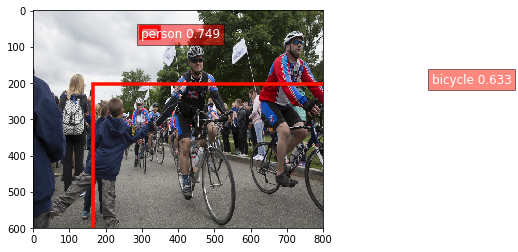

In [77]:
%matplotlib inline

from gluoncv import utils
from matplotlib import pyplot as plt


ax = utils.viz.plot_bbox(img, clean_box, clean_sco,
                         clean_cids, class_names=classes_name)
plt.show()



In [40]:
from gluoncv import model_zoo

net = model_zoo.get_model('faster_rcnn_resnet50_v1b_coco', pretrained=True)

net.features.save_parameters("features.params")
net.top_features.save_parameters("topfeatures.params")
net.global_avg_pool.save_parameters("global_avg_pool.params")
net.class_predictor.save_parameters("class_predictor.params")
net.box_predictor.save_parameters("box_predictor.params")
net.rpn.conv1.save_parameters("rpn_conv1.params")
net.rpn.score.save_parameters("rpn_score.params")
net.rpn.loc.save_parameters("rpn_loc.params")